<a href="https://colab.research.google.com/github/sam-vermeulen/MATH4600-Research-Project/blob/main/Connect_Four.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import time

jax.config.update("jax_enable_x64", True)

N_ROW = 6
N_COL = 7

assert N_ROW * N_COL << 64

BITBOARD = jnp.uint64
PIECE_LOCATIONS = jnp.array( [[ 2**(col + N_COL * row)  for col in range(N_COL)] for row in range(N_ROW)], dtype = BITBOARD)
ILLEGAL_MOVE_FLAG = -1

## BITBOARD HELPER FUNCTIONS

In [62]:
def is_subset(bb_sub, bb_super):
  return jnp.bitwise_and(bb_sub, jnp.bitwise_not(bb_super)) == 0

def is_empty_intersection(bb_sub, bb_super):
  return jnp.bitwise_and(bb_sub, bb_super) == 0

def bitboard_to_array(bitboard):
  '''Converts a bitboard to a boolean array'''
  # input: bitboard - a bitboard
  # output: the array representation of the bitboard
  return jnp.bitwise_not(is_empty_intersection(bitboard, PIECE_LOCATIONS))

def array_to_bitboard(array):
  '''Converts an boolean array to a bitboard'''
  # input: array - a boolean array
  # output: the bitboard representatino of the array
  return jnp.sum(jnp.sum(array * PIECE_LOCATIONS, axis=-1), axis=-1)

def GenerateKinARow(k):
    '''Return an array with all the boards that contain k pieces in a line'''
    # input: k an integer
    # output: A bb vector of shape (N_k_in_a_lines,) with all the k in a lines
    # rmk: Uses some numpy functions for convenience in the loop
    return jnp.array(
        [ np.sum([PIECE_LOCATIONS[x,y+i] for i in range(k)]) for x,y in np.ndindex(N_ROW,N_COL-k+1)] +
        [ np.sum([PIECE_LOCATIONS[x+i,y] for i in range(k)]) for x,y in np.ndindex(N_ROW-k+1,N_COL)] +
        [ np.sum([PIECE_LOCATIONS[x+i,y+i] for i in range(k)]) for x,y in np.ndindex(N_ROW-k+1,N_COL-k+1)] +
        [ np.sum([PIECE_LOCATIONS[x+i,N_COL-1-(y+i)] for i in range(k)]) for x,y in np.ndindex(N_ROW-k+1,N_COL-k+1)]
        ,dtype=BITBOARD)

FOUR_IN_A_LINE = GenerateKinARow(4)

## CONNECT FOUR

In [141]:
class ConnectFour():
  '''Connect Four Game (Parallel)'''

  # game_info - bitboard array of shape (n_game, 2)
  # move_info - the index that a piece would settle if it would be played in the 
  #           - of shape (..., 5)
  # player_ix - the current players in all games
  # active_games - (..., 1) boolean array of active games

  def __init__(self, n_games = 1, starting_player = 0, dtype=BITBOARD):
    
    self.player_ix = starting_player
    self.n_games = n_games
    self.game_state = jnp.zeros((n_games, 2), dtype=BITBOARD)
    self.move_info = (N_ROW - 1) * jnp.ones((n_games, N_COL), dtype = int)
    self.active_games = jnp.ones((n_games,1), dtype=bool)

  def get_possible_moves(self):
    '''Returns all the allowed moves from a given gamestate when it is playr_ix's turn'''

    # bitboard of all locations played
    played_bb = jnp.sum(self.game_state, axis=-1, dtype = BITBOARD)

    # boolean array of locations that have been played
    unplayed_locs = is_empty_intersection(played_bb[..., jnp.newaxis, jnp.newaxis], PIECE_LOCATIONS)

    # bitboard array of pieces that havn't been played
    unplayed_bb = unplayed_locs * PIECE_LOCATIONS

    # maximum unplayed piece in each column
    max_unplayed_bb = jnp.amax(unplayed_bb, axis = -2)

    # row index of legal moves
    move_ix = (jnp.argmax(jnp.logical_not(unplayed_locs), axis=-2) - 1) % N_ROW

    p0_move = jnp.stack([max_unplayed_bb, jnp.zeros_like(max_unplayed_bb)], axis=-1) 

    moves = jax.lax.cond(self.player_ix == 0, lambda x:x, lambda x:jnp.flip(x, axis=-1), p0_move)

    new_game_states = self.game_state[..., jnp.newaxis, :] | moves

    legal = (max_unplayed_bb > 0)

    move_info = jnp.where(legal, move_ix, ILLEGAL_MOVE_FLAG)

    return new_game_states, move_info

  def play_move(self, choice):
    #Input:
    #  choice =  An integer array of shape (...) with which move is to be played 
    #Output: A tuple moves, legal
    #  new_game_state = A bb array of shape (...,2) with the 
    #        postion after all the possible moves
    #  move_info = An array of shape (...,N_Possible_Moves) with info on the N_Possible_Moves 
    #             If the move is legal: The ROW the move will be played in
    #             If the move is illegal: A Illegal_Move_Flag (= -1)

    #The index of the row to play in (computed using move_info)
    # shape: (pre-shape, 1)
    chosen_col = jnp.expand_dims(choice, axis=-1)
    chosen_row = jnp.take_along_axis(self.move_info, chosen_col, axis=-1)

    # The bb of the piece to be played (note we reduce the dimension down)
    # shape: (pre-shape)
    move_pieces = jnp.squeeze(PIECE_LOCATIONS[chosen_row, chosen_col], axis=-1)

    # The bb of the state to be added on if its p0's turn
    # shape: (pre-shape,2)
    p0_move = jnp.stack([move_pieces, jnp.zeros_like(move_pieces)], axis=-1) 
    
    # For the other player we have to swap these
    # We put this if statement into lax.cond instead of "if" so it is jit-able
    the_move = jax.lax.cond(self.player_ix == 0, lambda x:x, lambda x:jnp.flip(x,axis=-1), p0_move)
    
    #Add the moves to the game_state and ensure correct brodcasting
    # Note: we use | instead of + for safety/speed...it shouldn't matter!
    # shape: (pre-shape, 2)
    new_game_state = self.game_state | the_move
    # update move_info by subtracting one from each location where we played
    new_move_info = self.move_info - jax.nn.one_hot(choice, N_COL, dtype=int)

    self.game_state = jnp.where(self.active_games, new_game_state, self.game_state)
    self.move_info = jnp.where(self.active_games, new_move_info, self.move_info)
    self.player_ix = not self.player_ix

  def get_num_four_in_row(self, player_ix):
    '''Return the number of 4 in a lines in a single BitBoard'''
    #Input: player_ix - the player to check
    #Output A boolean (or an array of the same shape of boolean)
    return jnp.sum(is_subset(FOUR_IN_A_LINE, self.game_state[..., player_ix, jnp.newaxis]), axis=-1)

  def has_connect_four(self, player_ix):
    '''checks if player player_ix has four in a row'''
    #input: player_ix - the player to check
    return self.get_num_four_in_row(player_ix) > 0

  def draw_game(self, game_num = 0, player_color = ['red','black']):
    '''Use matplotlib to draw the board in text given the bitboards for player 1 and player 2'''
    #Input: A game_state of shape (2,) with two bitboards
    #Output: Draws a graph with the game 

    fig, ax = plt.subplots() 
    plt.xlim(-0.5, N_COL - 0.5)
    plt.ylim(N_ROW - 0.5, -0.5)
    ax.patch.set_facecolor('lightgrey')

    piece_array = jnp.array([bitboard_to_array(self.game_state[game_num][0]), bitboard_to_array(self.game_state[game_num][1])]) 

    for x in range(N_COL):
      for y in range(N_ROW):
        outline = plt.Circle((x,y), 0.45, color='white')
        ax.add_patch(outline)

        for player_ix in range(2):
          if piece_array[player_ix, y,x]:
            piece = plt.Circle((x,y), 0.45, color = player_color[player_ix])
            ax.add_patch(piece)

  plt.show()

  def update_active_games(self):
    finished_games = jnp.bitwise_or(self.has_connect_four(0), self.has_connect_four(1))[:, jnp.newaxis]
    self.active_games = jnp.bitwise_not(finished_games)

## GAME

In [139]:
class RandomGamesSimulator():
  def __init__(self, n_games, starting_player, verbose = False):
    self.n_games = n_games
    self.starting_player = starting_player
    self.connect_four = ConnectFour(n_games = self.n_games, starting_player = self.starting_player)

  def start(self, key = None):
    if key == None:
      key = jax.random.PRNGKey(int(time.time()))

    for i in range(N_COL * N_ROW):
      key, subkey = jax.random.split(key)

      # randomly chooses a legal column to play piece.
      scores = jax.random.uniform(key, jnp.shape(self.connect_four.move_info))
      illegal_moves = (self.connect_four.move_info == ILLEGAL_MOVE_FLAG)
      scores = jnp.where(illegal_moves, jnp.nan, scores)
      choices = jnp.nanargmax(scores, axis=-1)

      # play move choice and update the active games.
      self.connect_four.play_move(choices)
      self.connect_four.update_active_games()

In [156]:
game = RandomGamesSimulator(n_games = 1_000_000, starting_player = 0)
game.start()

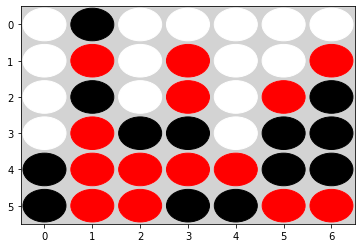

In [168]:
game.connect_four.draw_game(0)